# Analisis Sentimen Vidio.com di Google Play Store

Analisis sentimen merupakan teknik untuk mengelompokkan opini dalam bentuk teks ke dalam kategori emosi seperti *positif*, *negatif*, atau *netral*. Dalam proyek ini, analisis dilakukan terhadap **ulasan pengguna aplikasi Vidio.com**, yang diperoleh langsung dari Google Play Store melalui proses *scraping* menggunakan bahasa pemrograman Python.

**Tujuan:**
Proyek ini dibuat sebagai bagian dari submission kelas **Belajar Pengembangan Machine Learning di Dicoding**

**Dataset:**
- **Sumber Data:** Google Play Store (scraping manual dari aplikasi Vidio.com)
- **Jumlah Data Awal:** 15.000 ulasan
- **Setelah Preprocessing:** 12.300 ulasan
- **Distribusi Kelas:**
  - **Negatif:** 2.920
  - **Positif:** 4.328
  - **Netral:** 5.679


In [1]:
!pip install Sastrawi --quiet
!pip install nltk --quiet
!pip install transformers --quiet
!pip install keras-tuner --upgrade

In [2]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import torch
import re, string, requests
from io import StringIO
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Embedding, LSTM, Bidirectional
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from transformers import BertTokenizer, TFBertForSequenceClassification
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
nltk.download('all')

<ipython-input-2-be487a0f08a0>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...


True

In [3]:
df = pd.read_csv('vidio.csv')

## Data Explore dan Preprosessing

In [4]:
df.shape

(15000, 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  15000 non-null  object
dtypes: object(1)
memory usage: 117.3+ KB


In [6]:
df.head()

,Review
0,"Overall Sejauh ini BAGUS,Apalagi Sudah Berlang..."
1,udah langganan tp kok masih ada iklan? buka di...
2,"IKLAN NYA ILANGIN BANYAK BANGET ,SAMA SEMUA LA..."
3,"menurut aku ya, vidio nih kayak gimana gitu pa..."
4,oke


In [7]:
for row in range(0,5):
  print(df.iloc[row,0])

Overall Sejauh ini BAGUS,Apalagi Sudah Berlangganan menggunakan IM3 Platinum yang memberikan akses Video tanpa iklan, bebas Nonton Serial Drama, Film genre apapun plus disini juga ada Live Streaming TV Indonesia maupun manca negara. Kalo bisa dipertahankan atau ditingkatkan dari segala Kualitas UI (User Interface) nya biar tidak buffering ketika play film/live streaming. Ttd Febrian, S.Pd., Gr
udah langganan tp kok masih ada iklan? buka di TV tiba2 juga log out sendiri dan gabisa masuk lagi. ampas
IKLAN NYA ILANGIN BANYAK BANGET ,SAMA SEMUA LAGI MENDING YT DARI PADA INI YT IKLAN NYA CUMA 1-2 DOANG DAN BEDA² TRS GA MAKSA DISINI IKLANNYA MAKSA BNGT NJS
menurut aku ya, vidio nih kayak gimana gitu padahal sinyal bagus tapi kalo mau nonton live selalu loading
oke


In [8]:
df.isna().sum()

,0
Review,0


In [9]:
df.duplicated().sum()

np.int64(2073)

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df.shape

(12927, 1)

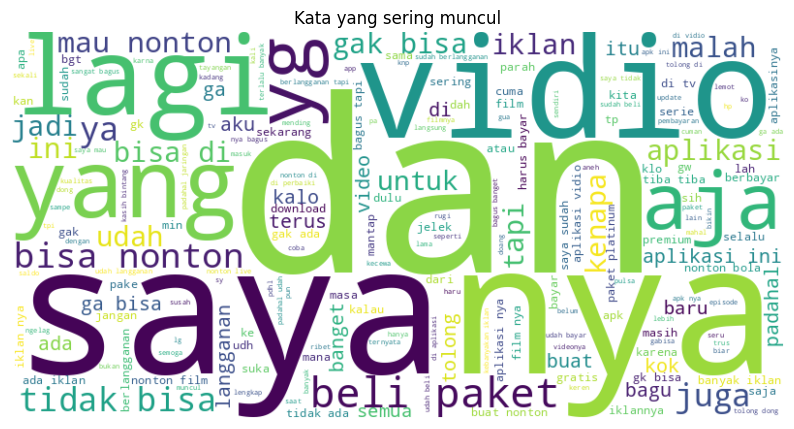

In [13]:
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Review']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.title('Kata yang sering muncul')
plt.axis('off')
plt.show()

In [14]:
print(string.punctuation)
print(string.digits)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
0123456789


In [15]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

In [16]:
def casefoldingText(text):
    return text.lower()

In [17]:
df_slang = pd.read_csv('kamusalay.csv')

In [18]:
print(df_slang)

       ajh     saja
0      ajj     saja
1     akoh      aku
2    amaca  ah masa
3     amuh     kamu
4      aph      apa
..     ...      ...
232    yap       ya
233    yaw       ya
234    yoi      iya
235   yups       ya
236   yupz       ya

[237 rows x 2 columns]


In [19]:
# Mengubah ke dictionary
kamus_slang = dict(zip(df_slang['ajh'], df_slang['saja']))

In [26]:
def slangword(text, kamus_slang):
    if pd.isnull(text):
        return ""
    tokens = re.findall(r'\b\w+\b', str(text).lower())  # Ambil kata aja (hindari tanda baca)
    hasil = [kamus_slang.get(token, token) for token in tokens]
    return " ".join(hasil)

In [21]:
def tokenizingText(text):
    return re.findall(r'\b\w+\b', text)

In [22]:
def filteringText(text_tokens):
    listStopwords = set(stopwords.words('indonesian') + stopwords.words('english'))
    listStopwords.update([
        'yg', 'dengan', 'saya', 'ini', 'di', 'untuk', 'saja', 'dan', 'ada', 'juga', 'dah', 'bbm',
        'otp', 'lagi', 'lebih', 'terus', 'tolong', 'masih', 'sama', 'aja', 'aplikasi', 'pertamina',
        'udah', 'seperti', 'apa', 'game', 'gitu', 'sebagai', 'mau', 'buat', 'akan', 'masalah',
        'kok', 'harusnya', 'sudah', 'tp', 'atau', 'login', 'register', 'update', 'akun', 'server',
        'spbu', 'pakai', 'aplikasinya', 'ketika', 'langsung', 'kadang', 'menurut', 'masuk', 'pengguna',
        'buka', 'coba', 'bantu', 'baru', 'selalu', 'banyak', 'kali', 'mudah', 'dari', 'oke',
        'bukan', 'ingin', 'terlihat', 'pada', 'saja', 'masih', 'kita', 'sistem', 'kenapa', 'langsung',
        'yang', 'pengguna', 'gue', 'nya', 'itu', 'ternyata', 'ya', 'yaa', 'kode',
        'jadi', 'daftar', 'pa', 'apk', 'app', 'hp', 'gaa', 'yaa', 'ngaa', 'bayar', 'bisa', 'ga',
        'download', 'bikin', 'banget', 'pake', 'ulang', 'beli','padahal','jg','juga','kan','kok',
        'sih','gimana','gamenya','bagu','sya','g','y','link','moga'
    ])
    return [word for word in text_tokens if word not in listStopwords]

In [23]:
def toSentence(list_words):
    return ' '.join(list_words)

In [24]:
stemmer = StemmerFactory().create_stemmer()
def stemmingText(text):
    return stemmer.stem(text)

In [28]:
df['clean_text'] = df['Review'].apply(cleaningText)
df['clean_text'] = df['clean_text'].apply(casefoldingText)
df['clean_text'] = df['clean_text'].apply(lambda x: slangword(x, kamus_slang))
df['tokens'] = df['clean_text'].apply(tokenizingText)
df['tokens'] = df['tokens'].apply(filteringText)
df['text_final'] = df['tokens'].apply(toSentence)
df['text_final'] = df['text_final'].apply(stemmingText)

In [29]:
lex_pos = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
lex_neg = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

df_pos = pd.read_csv(StringIO(lex_pos.text))
df_neg = pd.read_csv(StringIO(lex_neg.text))

pos_col = df_pos.columns[0]
neg_col = df_neg.columns[0]

positive_words = set(df_pos[pos_col])
negative_words = set(df_neg[neg_col])

def label_sentiment(text):
    tokens = text.split()
    pos_count = sum(1 for word in tokens if word in positive_words)
    neg_count = sum(1 for word in tokens if word in negative_words)
    if pos_count > neg_count:
        return 'positif'
    elif neg_count > pos_count:
        return 'negatif'
    else:
        return 'netral'

df['label'] = df['text_final'].apply(label_sentiment)
df = df[df['label'].isin(['positif', 'negatif', 'netral'])]

In [60]:
df['label'].value_counts()

,count
label,
netral,5679
positif,4328
negatif,2920


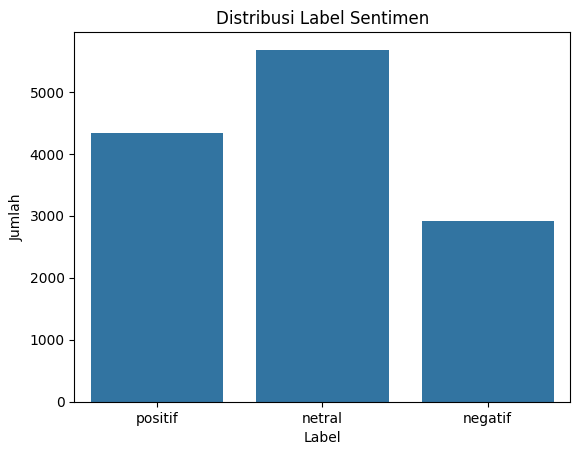

In [30]:
sns.countplot(data=df, x='label')
plt.title("Distribusi Label Sentimen")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

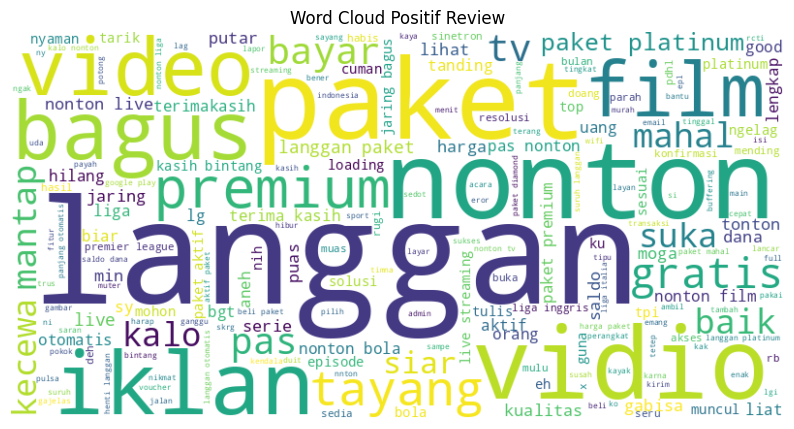

In [31]:
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df['label'] == 'positif']['text_final']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud Positif Review')
plt.axis('off')
plt.show()

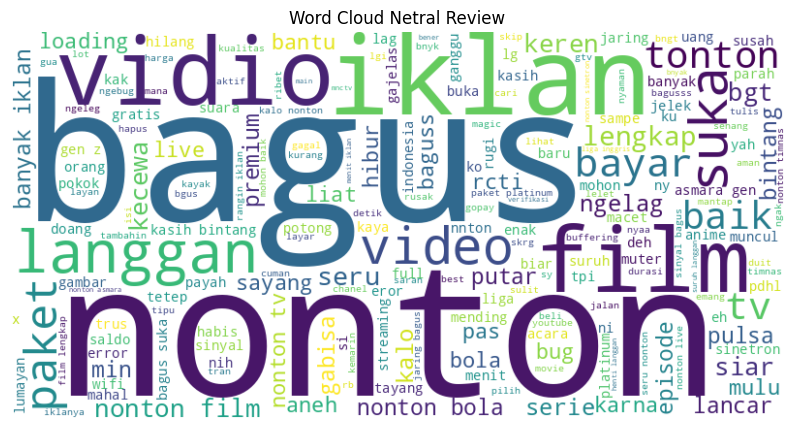

In [32]:
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df['label'] == 'netral']['text_final']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud Netral Review')
plt.axis('off')
plt.show()

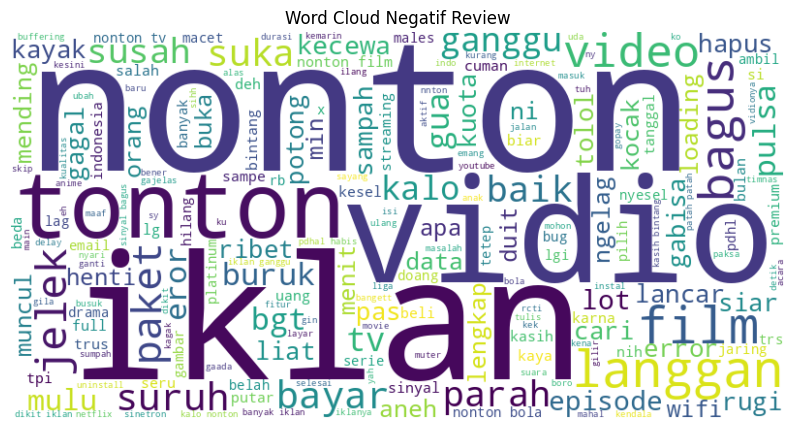

In [33]:
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df['label'] == 'negatif']['text_final']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud Negatif Review')
plt.axis('off')
plt.show()

In [34]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

In [35]:
df=df.dropna(subset=['text_final'])

In [36]:
df['text_final']=df['text_final'].astype(str)

In [37]:
df.head()

,Review,clean_text,tokens,text_final,label,label_encoded
0,"Overall Sejauh ini BAGUS,Apalagi Sudah Berlang...",overall sejauh ini bagusapalagi sudah berlangg...,"[overall, bagusapalagi, berlangganan, im, plat...",overall bagusapalagi langgan im platinum akses...,positif,2
1,udah langganan tp kok masih ada iklan? buka di...,sudah langganan tapi kok masih ada iklan buka ...,"[langganan, iklan, tv, log, gabisa, ampas]",langgan iklan tv log gabisa ampas,netral,1
2,"IKLAN NYA ILANGIN BANYAK BANGET ,SAMA SEMUA LA...",iklan nya ilangin banyak banget sama semua lag...,"[iklan, ilangin, mending, yt, yt, iklan, doang...",iklan ilangin mending yt yt iklan doang beda t...,negatif,0
3,"menurut aku ya, vidio nih kayak gimana gitu pa...",menurut aku ya vidio nih kayak gimana gitu pad...,"[vidio, nih, kayak, sinyal, bagus, kalo, nonto...",vidio nih kayak sinyal bagus kalo nonton live ...,netral,1
4,oke,oke,[],,netral,1


In [39]:
df_preprocessed =  df[['Review', 'text_final', 'label', 'label_encoded']]
file_path = 'vidio_final.csv'
df_preprocessed.to_csv(file_path, index=False)

In [40]:
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

## Skema Pelatihan

### Deep Learning ANN Algoritma 80 20 TF-IDF (KERAS TUNER)

In [41]:
y = df['label_encoded']

In [42]:
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 1))
X_tfidf = vectorizer.fit_transform(df['text_final'])
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, stratify=y, test_size=0.2, random_state=42)

In [43]:
X_train_dl = X_train.toarray()
X_test_dl = X_test.toarray()

In [44]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

In [45]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_dl.shape[1],)))
    model.add(Dense(hp.Int('units1', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', values=[1e-3, 3e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='pertamina_segmentasi'
)

tuner.search(X_train_dl, y_train,
             validation_split=0.2,
             epochs=100,
             batch_size=32,
             class_weight=class_weights,
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)],
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Skema 1 Deep Learning + TF-IDF (Tuning)")
print(best_hp.values)

Trial 20 Complete [00h 00m 16s]
val_accuracy: 0.8946350812911987

Best val_accuracy So Far: 0.9091348648071289
Total elapsed time: 00h 07m 14s
Skema 1 Deep Learning + TF-IDF (Tuning)
{'units1': 192, 'dropout1': 0.30000000000000004, 'units2': 96, 'dropout2': 0.4, 'lr': 0.0003}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
train_acc = best_model.evaluate(X_train_dl, y_train, verbose=0)[1]
test_acc = best_model.evaluate(X_test_dl, y_test, verbose=0)[1]
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Train Accuracy: 0.9735035300254822
Test Accuracy: 0.9056457877159119


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       584
           1       0.87      0.93      0.90      1136
           2       0.95      0.92      0.93       866

    accuracy                           0.91      2586
   macro avg       0.91      0.90      0.90      2586
weighted avg       0.91      0.91      0.91      2586



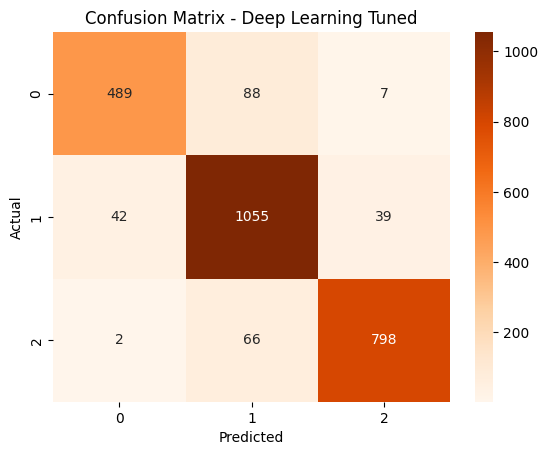

In [47]:
pred_dl = np.argmax(best_model.predict(X_test_dl), axis=1)
print(classification_report(y_test, pred_dl))
sns.heatmap(confusion_matrix(y_test, pred_dl), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Deep Learning Tuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [48]:
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [49]:
best_model.save('dl_scema1.keras')

### SVM Algoritma 70 30 TF-IDF

In [50]:
vectorizer_svm = TfidfVectorizer(max_features=10000, ngram_range=(1, 1))
X_svm = vectorizer_svm.fit_transform(df['text_final'])
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y, stratify=y, test_size=0.3, random_state=42)

In [51]:
svm_model = SVC(C=10, kernel='linear', class_weight='balanced')
svm_model.fit(X_train_svm, y_train_svm)

SVC(C=10, class_weight='balanced', kernel='linear')

In [52]:
train_acc_svm = svm_model.score(X_train_svm, y_train_svm)
test_acc_svm = svm_model.score(X_test_svm, y_test_svm)
print("Train Accuracy (SVM):", train_acc_svm)
print("Test Accuracy (SVM):", test_acc_svm)

Train Accuracy (SVM): 0.9997789566755084
Test Accuracy (SVM): 0.9071925754060325


              precision    recall  f1-score   support

           0       0.92      0.84      0.88       876
           1       0.87      0.93      0.90      1704
           2       0.96      0.92      0.94      1299

    accuracy                           0.91      3879
   macro avg       0.91      0.90      0.90      3879
weighted avg       0.91      0.91      0.91      3879



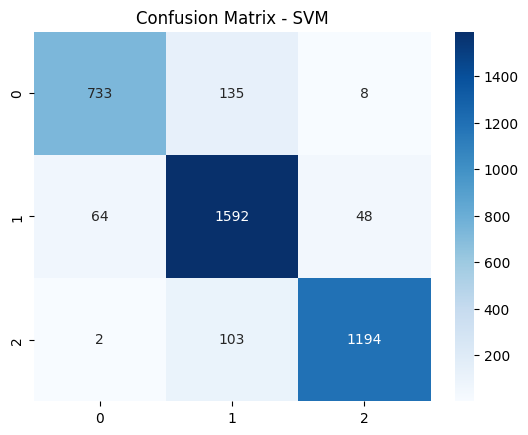

In [53]:
pred_svm = svm_model.predict(X_test_svm)
print(classification_report(y_test_svm, pred_svm))
sns.heatmap(confusion_matrix(y_test_svm, pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.show()

In [54]:
joblib.dump(svm_model, 'svm_model_tfidf.pkl')
joblib.dump(vectorizer_svm, 'tfidf_vectorizer_svm.pkl')

['tfidf_vectorizer_svm.pkl']

### Bidirectional LSTM Algoritma 90 10 Tokenization & Embedding (KERAS TUNER)

Trial 30 Complete [00h 00m 53s]
val_accuracy: 0.930382490158081

Best val_accuracy So Far: 0.937258243560791
Total elapsed time: 00h 25m 44s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



📊 Skema LSTM Tuned
Best Hyperparameters: {'embed_dim': 200, 'lstm_units': 128, 'dropout1': 0.2, 'dense_units': 32, 'dropout2': 0.30000000000000004, 'lr': 0.001}
Train Accuracy: 0.9856455326080322
Test Accuracy: 0.9242072701454163
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       292
           1       0.91      0.93      0.92       568
           2       0.95      0.92      0.94       433

    accuracy                           0.92      1293
   macro avg       0.93      0.92      0.92      1293
weighted avg       0.92      0.92      0.92      1293



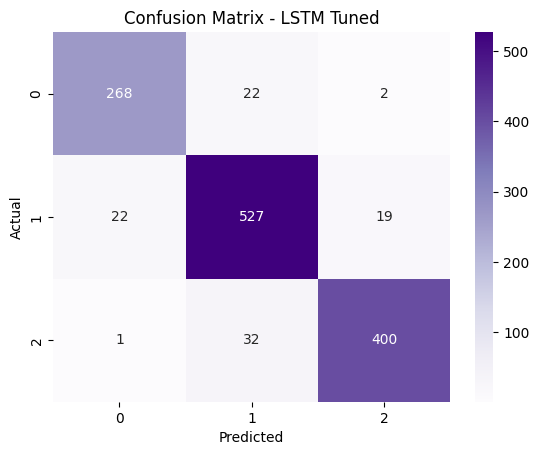

In [55]:
max_words = 10000
max_len = 100
tokenizer_lstm = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer_lstm.fit_on_texts(df['text_final'])
X_seq = tokenizer_lstm.texts_to_sequences(df['text_final'])
X_pad = pad_sequences(X_seq, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, stratify=y, test_size=0.1, random_state=42)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

def build_lstm_model(hp):
    model = Sequential()
    model.add(Input(shape=(max_len,)))
    model.add(Embedding(input_dim=max_words, output_dim=hp.Choice('embed_dim', [100, 150, 200])))
    model.add(Bidirectional(LSTM(hp.Choice('lstm_units', [64, 128]), return_sequences=False)))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(Dense(hp.Choice('dense_units', [32, 64, 128]), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 3e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='lstm_dir',
    project_name='lstm_1'
)

tuner.search(X_train, y_train,
             validation_split=0.2,
             epochs=100,
             batch_size=32,
             class_weight=class_weights,
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)],
             verbose=1)

best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("\n📊 Skema LSTM Tuned")
print("Best Hyperparameters:", best_hp.values)

train_acc = best_model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = best_model.evaluate(X_test, y_test, verbose=0)[1]
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

pred_lstm = np.argmax(best_model.predict(X_test), axis=1)
print(classification_report(y_test, pred_lstm))
sns.heatmap(confusion_matrix(y_test, pred_lstm), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - LSTM Tuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
best_model.save("lstm.keras")

In [57]:
with open("tokenizer_lstm.pkl", "wb") as f:
    joblib.dump(tokenizer_lstm, f)

In [58]:
params = {"max_words": max_words, "max_len": max_len}
with open("lstm_params.pkl", "wb") as f:
    joblib.dump(params, f)

## Results Final

### Skema 1: ANN + TF-IDF (80 20)
- **Ekstraksi Fitur:** TF-IDF (2000 fitur, ngram (1,1) )
- **Split Data:** 80:20
- **Model:** Sequential (2 Hidden Layers)
- **Tuning:** Keras Tuner
- **Akurasi:**
  - Train: ±97%
  - Test: ±90%

### Skema 2: SVM + TF-IDF (70 30)
- **Ekstraksi Fitur:** TF-IDF (10000 fitur)
- **Split Data:** 70:30
- **Model:** Support Vector Machine (Linear)
- **Akurasi:**
  - Train: ±99%
  - Test: ±90%

### Skema 3: LSTM + Embedding (90 10)
- **Ekstraksi Fitur:** Tokenizer + Embedding Layer
- **Split Data:** 90:10
- **Model:** Bidirectional LSTM
- **Tuning:** Keras Tuner (30 trials)
- **Best Hyperparameter:** 100-dim embed, LSTM 64, Dropout 0.2, LR 3e-4
- **Akurasi:**
  - Train: 98%
  - Test: **92%**
- Sangat Optimal (tertinggi)

### Kesimpulan:
- Dataset valid hasil scraping mandiri (12.300 sampel dari 15.000 data mentah)
- Tiga skema pelatihan model digunakan, masing-masing dengan variasi fitur, algoritma, dan split data
- Seluruh skema menghasilkan akurasi **test set ≥ 85%**, dan salah satu skema (LSTM) memiliki **akurasi training dan testing ≥ 92%**
- Struktur label tiga kelas: negatif, netral, positif




In [59]:
!pip freeze

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.2
astropy-iers-data==0.2025.5.12.0.38.29
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.4.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.3.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.10.0
click==8.2.0
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet